In [33]:


import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp
import spatial_metrics.spatial_metrics_calcium_base as pl

%matplotlib widget


- Parameters for Filename Creation and Saving:
    These parameters assist in constructing a filename and saving the results. If you do not wish to save the results and prefer to work with the object directly, you can ignore these settings by setting the 'saving' flag to False.
    - 'saving_string': Prefix used for creating the filename to save the results.
    - 'animal_id': Identifier for the animal.
    - 'dataset': Name of the dataset.
    - 'day': Session or day of the experiment.
    - 'neuron': Identifier for the neuron.
    - 'trial': Identifier for the trial.
    - 'saving_path': Directory path where the results will be saved.
    - 'saving': Boolean flag indicating whether to save the results (True) or not (False).

- Parameters for Signal and Tracking:
    - 'sampling_rate': The rate at which the signal and tracking data are sampled.
    - 'environment_edges': Coordinates defining the boundaries of the environment.

- Inclusion Criteria for Analysis:
    - 'min_time_spent': Minimum time an animal must spend in each xy bin to be considered.
    - 'min_visits': Minimum number of visits required to each xy bin.
    - 'min_speed_threshold': Minimum speed threshold in coordinate units for the analysis.

- Information Parameters:
    - 'x_bin_size': Size of x bins in coordinate units used to calculate mutual information.
    - 'y_bin_size': Size of y bins in coordinate units used to calculate mutual information.
    - 'nbins_cal': Number of calcium signal bins used to calculate mutual information.

    Note: for x,y bin size, you should input the bin size; for calcium signal, you input the total amount of bins that will equally slice calcium amplitude (min and max values of calcium signal).
    
- Surrogate Analysis Parameters:
    - 'shift_time': Time shift window (in seconds) for creating surrogate distributions by randomly shifting the signal from -shift_time to +shift_time.
    - 'num_cores': Number of CPU cores to be used for the analysis. Set to -1 to utilize all available cores.
    - 'num_surrogates': Number of surrogate distributions to generate.

- Place Field Parameters:
    - 'smoothing_size': Size of the smoothing area in bins for plotting place fields.
    - 'percentile_threshold': Percentile threshold used to determine place field boundaries based on surrogate distributions.
    - 'min_num_of_bins': Minimum number of bins required to define a place field.

Note: Ensure that the variables input_signal,time_vector, x_coordinates and y_coordinates are vectors of the same size. You may need to downsample or upsample your signal or xy tracking coordinates to match their dimensions.


# If you have pre-existing data, bypass the previous code cells and load the data directly
# This is useful if you want to avoid re-running the preceding setup and instead work with already available data


In [34]:
# Load your data:
# input_signal,time_vector,x_coordinates,y_coordinates

# Load data
output_dict = np.load('simulated_signal.npy',allow_pickle=True).item()
signal = output_dict['signal']
time_vector = output_dict['time_vector']
x_coordinates = output_dict['x_coordinates']
y_coordinates = output_dict['y_coordinates']
modulated_spike_times_idx = output_dict['spike_times']
environment_edges = output_dict['environment_edges']
sampling_rate = output_dict['sampling_rate']


In [18]:
# Signal processing
# here you can modify your signal to test different preprocessing steps.
# then, choose one of them as the input_signal 

lower_band = 0
higher_band = 2
filtered_signal = hf.eegfilt(signal, sampling_rate, lower_band, higher_band, order=2)

diff_signal = np.hstack([np.diff(filtered_signal), 0])

diff_signal_truncated = np.copy(diff_signal)
diff_signal_truncated[diff_signal < 0] = 0



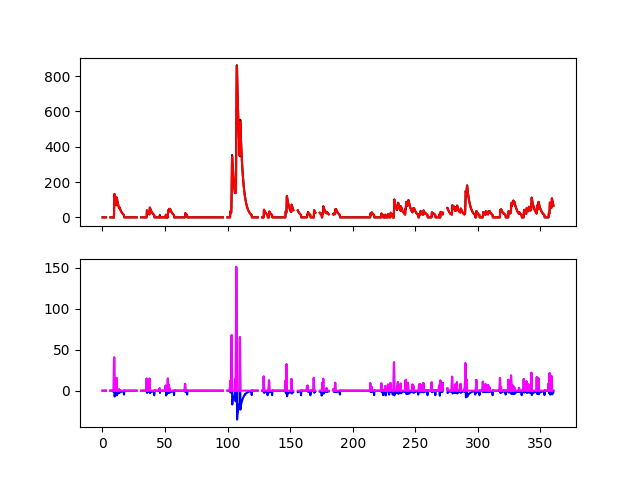

In [19]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(time_vector,signal,color = 'black')
ax1.plot(time_vector,filtered_signal,color ='red')

ax2.plot(time_vector,diff_signal,color ='blue')
ax2.plot(time_vector,diff_signal_truncated,color ='magenta')
plt.show()


In [35]:

# now input_signal will point to the desired signal

signal_type = 'Raw'
input_signal = signal.copy()
# input_signal = hf.min_max_norm(signal)

# signal_type = 'Filtered'
# input_signal = filtered_signal

# signal_type = 'Diff'
# input_signal = diff_signal

# signal_type = 'Diff_truncated'
# input_signal = diff_signal_truncated


In [36]:

# Calculate the video sampling rate as the reciprocal of the average time difference between consecutive timestamps.
# This is an approximation for cameras with varying frame rates.
sampling_rate = 1 / np.nanmean(np.diff(time_vector))

signal_type = 'Continuous'  # Define the type of signal being analyzed

# Create a dictionary to hold input parameters for further processing
input_dict = dict()

# Construct the filename and other identifiers for saving the results
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type  # Prefix for the filename
input_dict['animal_id'] = 'NeuronModel'  # Identifier for the animal or model
input_dict['dataset'] = 'Simulation'  # Name of the dataset
input_dict['day'] = 1  # Day or session number
input_dict['neuron'] = 1  # Neuron identifier
input_dict['trial'] = None  # Trial identifier (optional, can be None)
input_dict['saving_path'] = None  # Directory path for saving results (optional, can be None)
input_dict['saving'] = False  # Flag indicating whether to save the results (False means no saving)

# Set parameters related to the signal and environment
input_dict['sampling_rate'] = sampling_rate  # Sampling rate in points per second
input_dict['environment_edges'] = environment_edges  # Coordinates defining the edges of the environment (in cm)

# Set inclusion criteria for the analysis
input_dict['min_time_spent'] = 0  # Minimum time an animal must spend in each xy bin
input_dict['min_visits'] = 0  # Minimum number of visits required in each xy bin
input_dict['min_speed_threshold'] = 0  # Minimum speed threshold in coordinate units

# Set parameters for calculating mutual information
input_dict['x_bin_size'] = 1  # Size of x bins in coordinate units (cm)
input_dict['y_bin_size'] = 1  # Size of y bins in coordinate units (cm)
input_dict['nbins_cal'] = 10  # amount of calcium signal bins in coordinate units (cm)

# Set parameters for surrogate analysis
input_dict['shift_time'] = 200  # Time shift window in seconds for creating surrogate distributions
input_dict['num_cores'] = -1  # Number of CPU cores to use (set to -1 to use all available cores)
input_dict['num_surrogates'] = 80  # Number of surrogate distributions to generate

# Set parameters for plotting place fields
input_dict['smoothing_size'] = 1  # Size of the gaussian smoothing area in bins for plotting place fields

# Set parameters for place fields detection
input_dict['min_num_of_bins'] = 2  # Minimum number of bins required to define a place field

input_dict['field_detection_method'] = 'std_from_field'  # place field detection method ('std_from_field' or 'random_fields')

input_dict['percentile_threshold'] = 99  # Percentile threshold for determining place field boundaries when field_detection_method = 'random_fields'
input_dict['detection_threshold'] = 1 # place field detection threshold in std when field_detection_method = 'std_from_field'
input_dict['detection_smoothing_size'] = 1  # Size of the smoothing area in bins for detecting place fields when field_detection_method = 'std_from_field'

place_cell = pl.PlaceCell(**input_dict) # Instantiate the PlaceCell class with parameters
place_cell_output = place_cell.main(input_signal,time_vector,x_coordinates,y_coordinates)


SpatialMetrics.Continuous.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


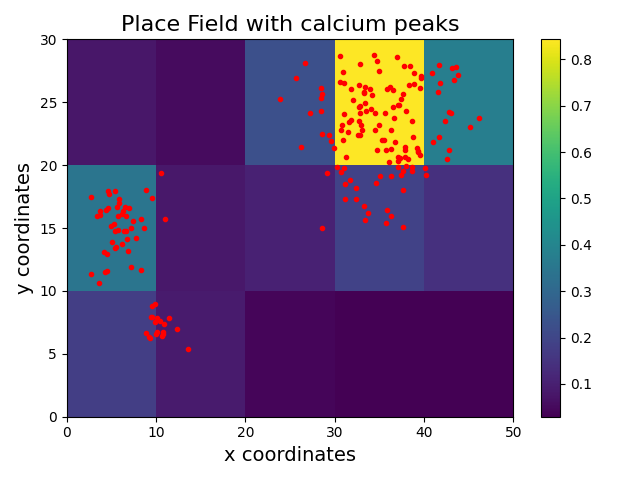

In [37]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'],shading = 'auto',edgecolors=None)
# plt.pcolormesh(place_cell_output['x_grid'],place_cell_output['y_grid'],place_cell_output['place_field'],edgecolors='red')

plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



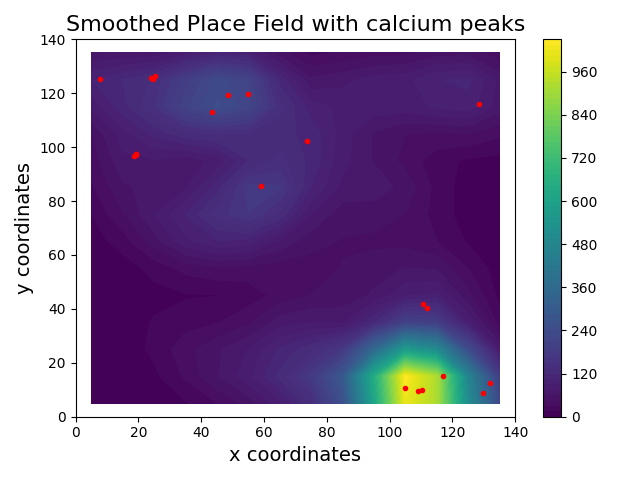

In [24]:


plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100,cmap='viridis')
plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



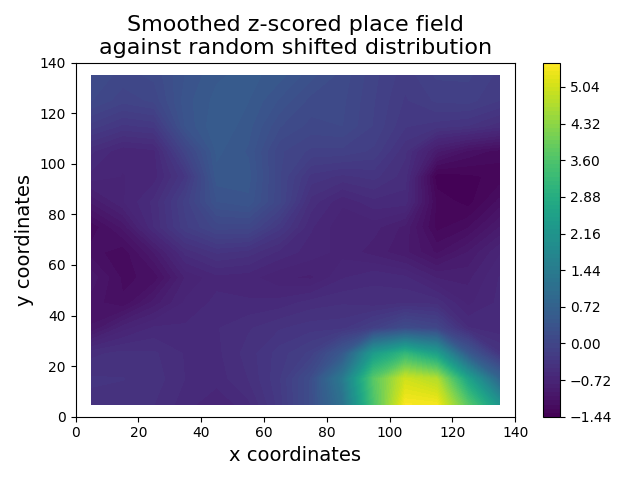

In [25]:

mean_place_field_shifted = np.nanmean(place_cell_output['place_field_smoothed_shifted'],0)
std_place_field_shifted = np.nanstd(place_cell_output['place_field_smoothed_shifted'],0)
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_smoothed_zscored = (place_field_smoothed - mean_place_field_shifted)/std_place_field_shifted

plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_field_smoothed_zscored,100)
plt.colorbar()
plt.title('Smoothed z-scored place field\nagainst random shifted distribution',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


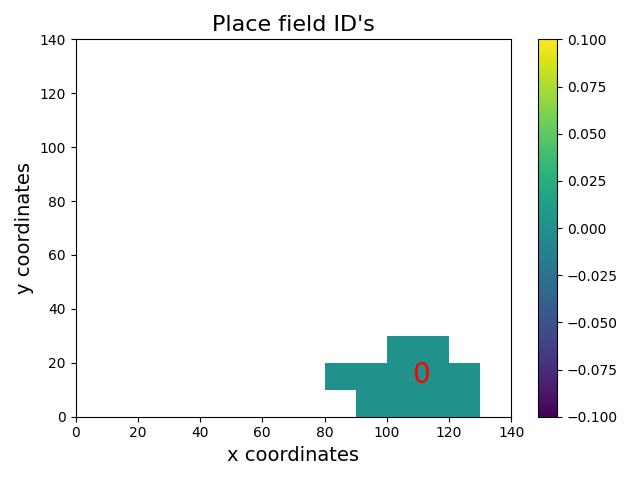

In [26]:

place_cells_x_center_coord = place_cell_output['islands_x_max']
place_cells_y_center_coord = place_cell_output['islands_y_max']

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_identity'])
plt.colorbar()


for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



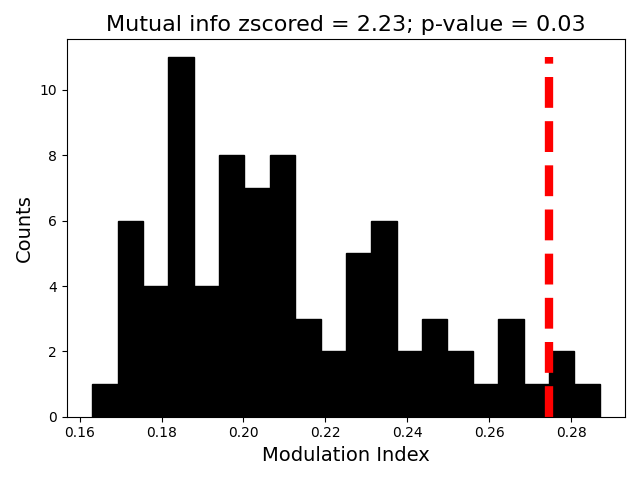

In [27]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shifted'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


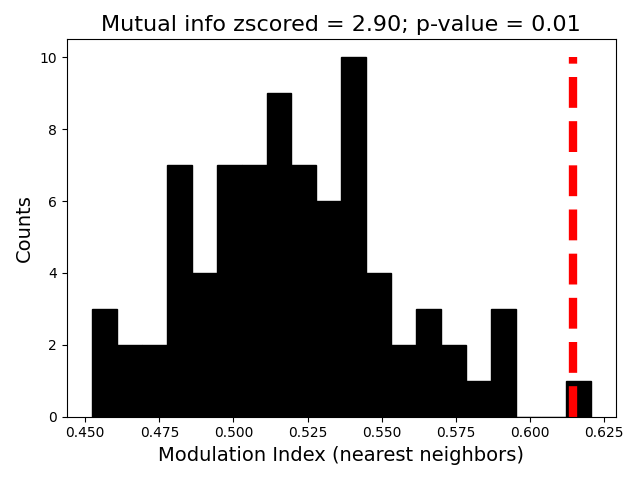

In [28]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_NN_shifted'] >= place_cell_output['mutual_info_NN_original'])/place_cell_output['mutual_info_NN_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_NN_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_NN_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_NN_original'],place_cell_output['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


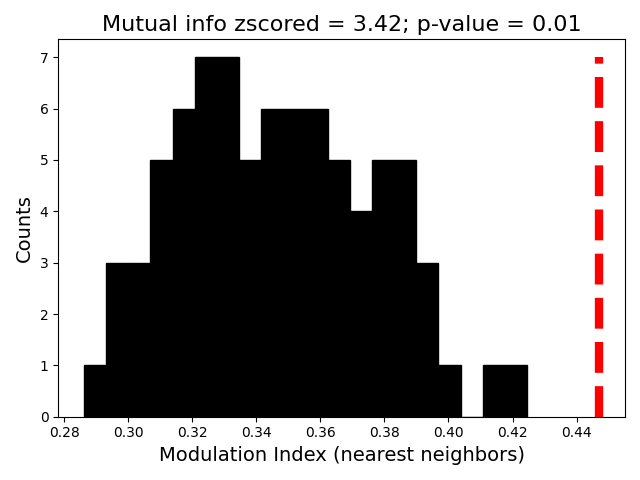

In [29]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_regression_shifted'] >= place_cell_output['mutual_info_regression_original'])/place_cell_output['mutual_info_regression_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_regression_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_regression_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_regression_original'],place_cell_output['mutual_info_regression_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_regression_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


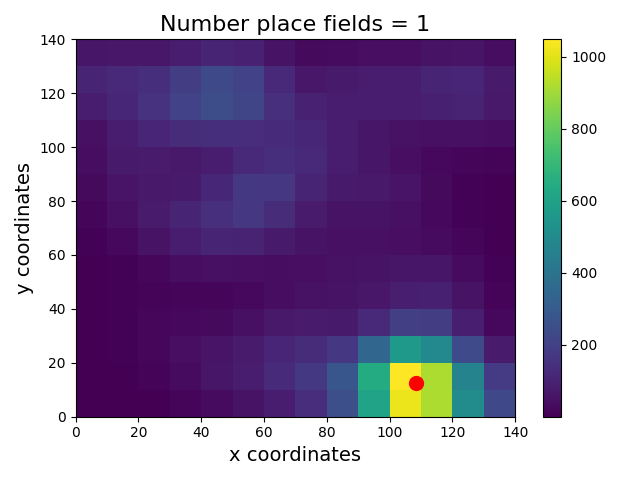

In [30]:
# place field identity and location
place_cells_x_center_coord = place_cell_output['islands_x_max']
place_cells_y_center_coord = place_cell_output['islands_y_max']

plt.figure()
# plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100)
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.plot(place_cells_x_center_coord,place_cells_y_center_coord,'r.',markersize=20)

plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


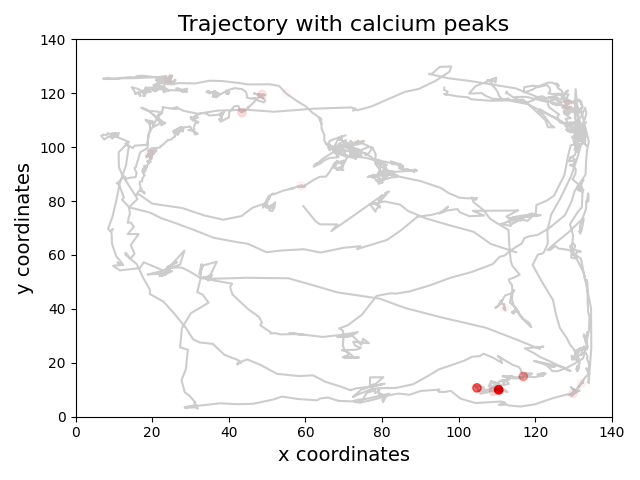

In [31]:
# The function normalizes peak amplitudes and uses them to set the transparency of each peak.
# Peaks with higher amplitudes are darker (less transparent) in the plot.

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


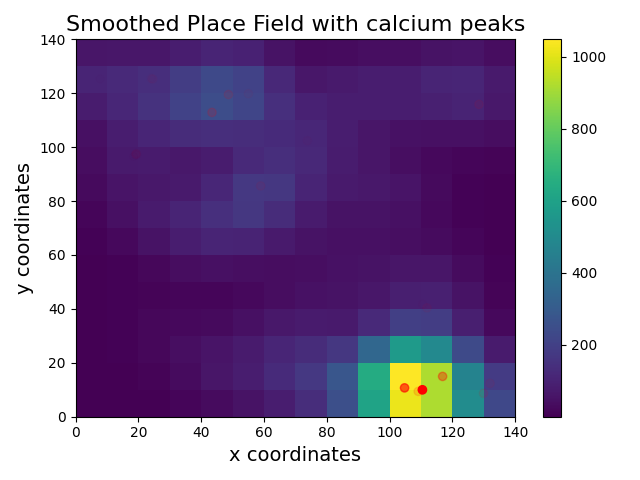

In [32]:
x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

events_amplitude = place_cell_output['events_amplitude']
events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])
    
plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'])
plt.colorbar()
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red')
plt.title('Smoothed Place Field with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


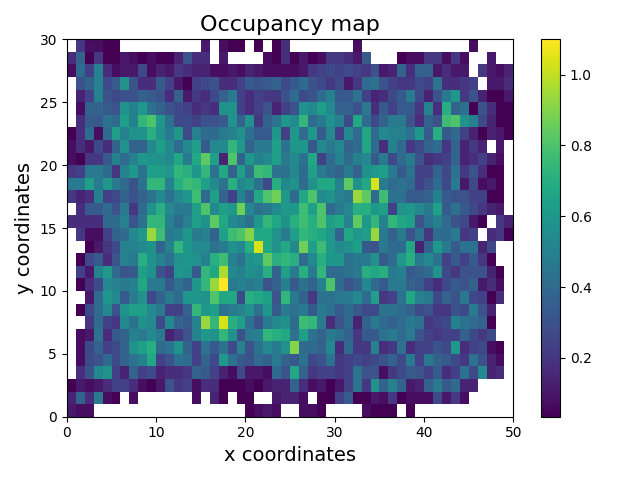

In [20]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['occupancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


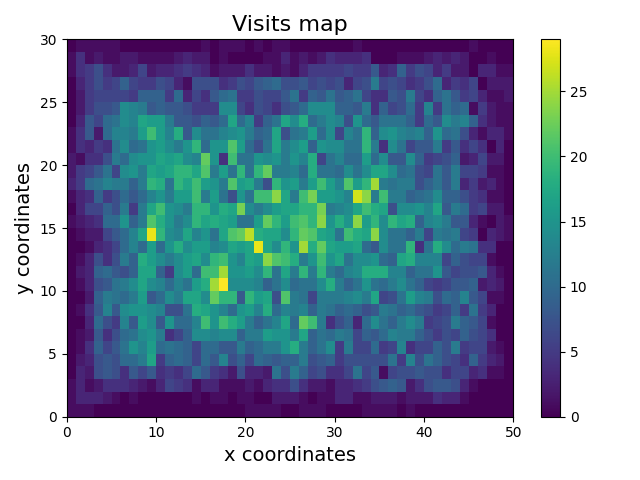

In [21]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


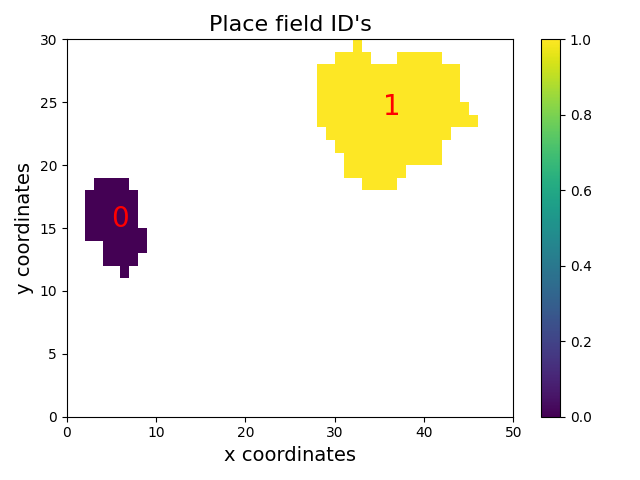

In [23]:
place_cells_x_center_coord = place_cell_output['islands_x_max']
place_cells_y_center_coord = place_cell_output['islands_y_max']

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_identity'])
plt.colorbar()


for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



In [24]:
# Place fields id's listed in place_cell_output['place_field_identity'] 
# can be used as indexes for place_cell_extension_absolute and place_cell_extension_relative


In [24]:
# Place field extension relative to the whole enviroment
place_cell_output['place_cell_extension_absolute']


array([0.026, 0.094])

In [25]:
# Place field extension relative to enviroment occupancy
place_cell_output['place_cell_extension_relative']


array([0.0289103 , 0.10452187])